In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools, places, geo_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
from matplotlib.colors import LogNorm
#import scipy.io as so

mpl.rc('xtick', labelsize=32)
mpl.rc('ytick', labelsize=32)
mpl.rc('legend', fontsize=32)
mpl.rc('axes', titlesize=32)
mpl.rc('axes', labelsize=32)
mpl.rc('figure', titlesize=32)
mpl.rc('font', size=32)
%matplotlib inline

In [2]:
choosepoint=False
if choosepoint==True:
    with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
        navlat=bathy.variables['nav_lat'][:,:]
        navlon=bathy.variables['nav_lon'][:,:]
    with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc') as mesh:
        tmask=mesh.variables['tmask'][0,:,:,:]
    indj,indi=geo_tools.find_closest_model_point(-123.93,49.75,navlon,navlat,land_mask=np.abs(tmask[0,:,:]-1))
    print(indj,indi)

    fig,ax=plt.subplots(1,1,figsize=(3,4))
    ax.pcolormesh(tmask[0,:,:])
    ax.plot(282,598,'r*')
    ax.set_ylim(550,700)
    ax.set_xlim(150,300)
    viz_tools.set_aspect(ax)

    fig,ax=plt.subplots(1,1,figsize=(3,2))
    ax.pcolormesh(tmask[:,598,:])
    ax.set_ylim(40,0)
    ax.plot(282,0,'r*')
    #ax.set_ylim(550,700)
    ax.set_xlim(150,300)
    #viz_tools.set_aspect(ax)
else:
    indj,indi=places.PLACES['Egmont']['NEMO grid ji']

In [3]:
chlToN=1.8
indk=0

In [4]:
datelims=(dt.datetime(1900,1,1),dt.datetime(2100,1,1))
start_date=datelims[0]
end_date=datelims[1]
sitelon,sitelat=places.PLACES['Egmont']['lon lat']
citez=1.0

In [5]:
df0 = pd.read_excel('/ocean/shared/SalishSeaCastData/SOGDC/Egmont/Chlorophyll_2015_Egmont .xlsx',
                 sheet_name = 'archive',skiprows=7,usecols=[0,1],header=None,names=['datetime','fluor'],
                  dtype={0:str,1:float})

In [6]:
print(df0['datetime'].values[0])

2015-02-18 22:08:56


In [7]:
dts=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') for ii in df0['datetime'].values]
df0['dtUTC']=dts

In [8]:
df0.head()

,datetime,fluor,dtUTC
0,2015-02-18 22:08:56,0.48048,2015-02-18 22:08:56
1,2015-02-18 22:38:56,0.55132,2015-02-18 22:38:56
2,2015-02-18 23:08:56,0.59752,2015-02-18 23:08:56
3,2015-02-18 23:38:56,0.67298,2015-02-18 23:38:56
4,2015-02-19 00:08:56,0.65758,2015-02-19 00:08:56


In [9]:
## Note: 2 things I would recommend doing that I have not done here:
#  1) bin (average) observations to time interval of model output (1 hour)
#  2) fill in missing hours in observation dataset (with NaNs for obs values) 
#     so there are no gaps in the model timeseries returned below

In [10]:
PATH= '/results/SalishSea/nowcast-green.201812/'
start_date = df0['dtUTC'].iloc[0]
end_date = df0['dtUTC'].iloc[-1]+dt.timedelta(days=1)
flen=1
namfmt='nowcast'
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T',
         'ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
fdict={'ptrc_T':1,'grid_T':1}
df0['i']=indi
df0['j']=indj
df0['k']=indk

In [11]:
# note: I only ran the first 200 data points to save time
df=et.matchData(df0.iloc[:200],filemap,fdict,start_date,end_date,namfmt,PATH,1,preIndexed=True);

In [12]:
df['mod_chl']=chlToN*(df['mod_diatoms']+df['mod_ciliates']+df['mod_flagellates'])

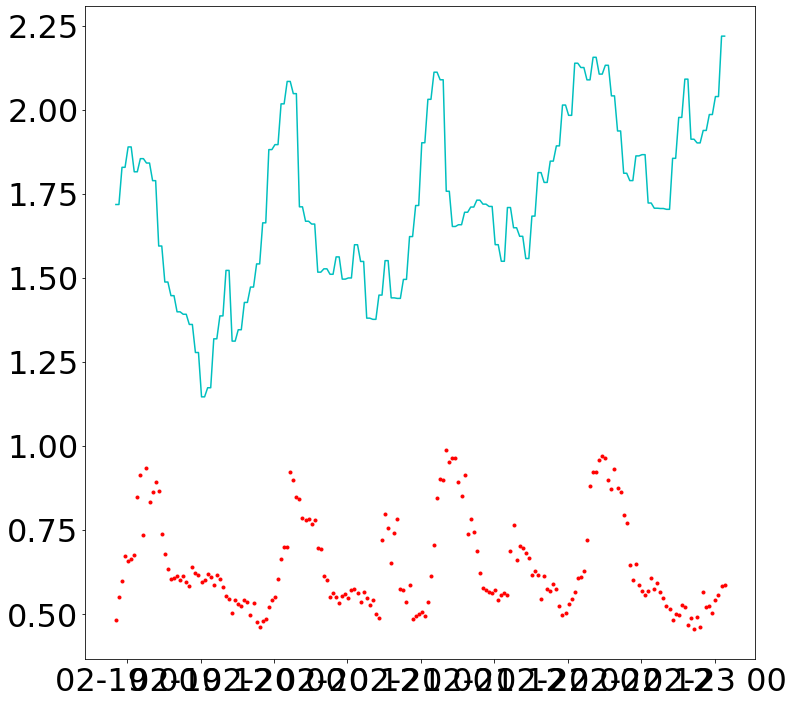

In [13]:
fig,ax=plt.subplots(1,1,figsize=(12,12))
ax.plot(df['dtUTC'],df['fluor'],'r.')
#var=chlToN*np.sum((f.variables['diatoms'][:,:2,0,0]+f.variables['ciliates'][:,:2,0,0]+f.variables['flagellates'][:,:2,0,0])*f.variables['e3t'][:,:2,0,0],1)/np.sum(f.variables['e3t'][:,:2,0,0],1)
ax.plot(df['dtUTC'],df['mod_chl'],'c-')

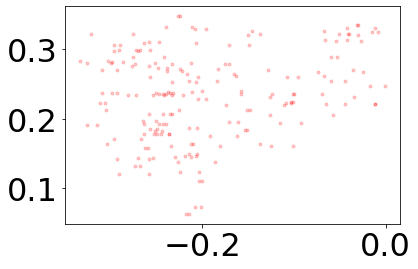

In [14]:
plt.plot(np.log10(df['fluor']+.01),np.log10(df['mod_chl']+.01),'r.',alpha=.2)

Text(0.5, 1.0, 'log10(Chlorophyll [$\\mu$gL$^{-1}$])')

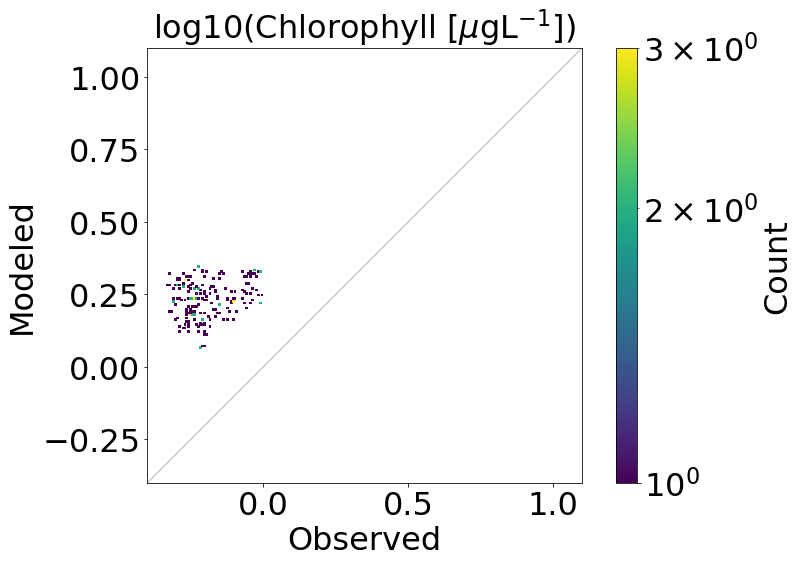

In [15]:
data=df
fig,ax=plt.subplots(1,1,figsize=(12,8))
iiCh=(~np.isnan(data['fluor']))&(~np.isnan(data['mod_chl']))
counts, xedges, yedges, m1=ax.hist2d(np.log10(data.loc[iiCh,['fluor']].values.flatten()+.01),
                                      np.log10(data.loc[iiCh,['mod_chl']].values.flatten()+.01),bins=25*2,norm=LogNorm())

ax.plot((-1,2),(-1,2),'k-',alpha=.2)
cb=fig.colorbar(m1)#,cax=axcb
cb.set_label('Count')
ax.set_xlim(-.4,1.1)
ax.set_ylim(-.4,1.1)
ax.set_aspect(1)
ax.set_ylabel('Modeled',fontsize=32)
ax.set_xlabel('Observed',fontsize=32)
ax.set_title('log10(Chlorophyll [$\mu$gL$^{-1}$])')
